# Code to calculate SNR of LIGO for certain event
by using the expression

## $ (\frac{S}{N})^2 = 4 \int_0^\infty df \frac{|h(f)|^2}{S_n(f)} $

Where $ |h(f)|^2 = h^* h $
and $ h = F_+h_+ + F_\times h_\times $

$S_n(f)$ = noise spectral  sensitivity = amp^2

frequency =f

In [10]:
import numpy as np
from scipy import interpolate
from pesummary.io import read
from scipy.integrate import *
import matplotlib.pyplot as plt

# for waveform genrator
import bilby
%matplotlib inline
%config InlineBackend.figure_format='retina'

## Here, we use: GW200311
They have 3 different modes:

IMRPhenomXPHM waveform, a phenomenological waveform including precession and higher modes

SEOBNRv4PHM waveform,   an effective one-body waveform including precession and higher modes

C01:Mixed:             A mixed set of samples created by combining both waveforms into one set


In [12]:
data = read("IGWN-GWTC3p0-v1-GW200311_115853_PEDataRelease_mixed_cosmo.h5")

index = 100
delta_f = 0.1
f_low = 10
f_high =1600

samples_dict = data.samples_dict
#posterior_samples = samples_dict["parameters"]

approximant2 = "IMRPhenomXPHM"
freqwave = samples_dict["C01:IMRPhenomXPHM"].maxL_fd_waveform(approximant2, delta_f, f_low, f_high)

2023-02-08  13:20:16 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2023-02-08  13:20:16 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2023-02-08  13:20:16 PESummary WARNING : Could not find minimum frequency in input file and one was not passed from the command line. Using 20.0Hz as default


## PSD, or the power spectral density
### is the same as $ S_n(f)$
is available from the data file.
There are from all the detectors; Hanford, Livingston, and Virgo(??)

dict_keys(['H1', 'L1', 'V1'])

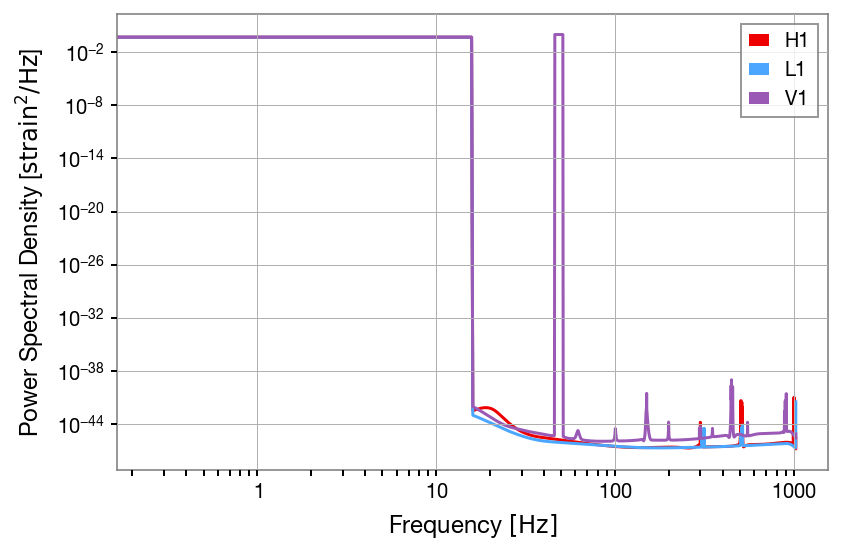

In [13]:
psd = data.psd["C01:IMRPhenomXPHM"]

psd_freq_h1 = psd['H1'][:,0] # frequency
psd_strain_h1 = psd['H1'][:,1] # strain

psd_freq_l1 = psd['L1'][:,0] # frequency
psd_strain_l1 = psd['L1'][:,1] # strain

psd_freq_v1 = psd['V1'][:,0] # frequency
psd_strain_v1 = psd['V1'][:,1] # strain

fig = psd.plot()#(fmin=16)   # fmin 15 is where we get the very high psd
ax = fig.gca()
psd.keys()

In [14]:
samples_dict = data.samples_dict
posterior_samples = samples_dict["C01:IMRPhenomXPHM"]
parameters = posterior_samples.parameters

ra = posterior_samples['ra'].mean()
dec = posterior_samples['dec'].mean()
psi = posterior_samples['psi'].mean()



# We can compare the GWaveform h from generator to real data

## Antenna functions

The detected signal at a given detector is projected using the antenna patter functions

$$h = F_+h_+ + F_\times h_\times$$

In [15]:
def Fp(RA,DEC,Psi): #(57) of https://arxiv.org/pdf/0903.0338.pdf
    phi = RA
    theta = np.pi/2.0 - DEC
    return 0.5*(1 + np.cos(theta)**2)*np.cos(2*phi)*np.cos(2*Psi) - np.cos(theta)*np.sin(2*phi)*np.sin(2*Psi)

def Fx(RA,DEC,Psi): #(57) of https://arxiv.org/pdf/0903.0338.pdf
    phi = RA
    theta = np.pi/2.0 - DEC
    return 0.5*(1 + np.cos(theta)**2)*np.cos(2*phi)*np.sin(2*Psi) + np.cos(theta)*np.sin(2*phi)*np.cos(2*Psi)



## Waveform generator program
it generates GW waveform  h_x , h_+ with corresponding input from the actual target; we could compare

In [16]:
def waveform(Binary_parameters, Waveform_arguments):
    duration = 4.0
    sampling_frequency = 2048.0

    waveform_generator = bilby.gw.WaveformGenerator(duration = duration,
        sampling_frequency = sampling_frequency,
        frequency_domain_source_model = bilby.gw.source.lal_binary_black_hole,
        parameter_conversion = bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters,
        waveform_arguments = Waveform_arguments,
    )
    
    gen_h = waveform_generator.frequency_domain_strain(Binary_parameters)
    fs = bilby.core.utils.series.create_frequency_series(sampling_frequency,duration)

    hp = gen_h['plus']
    hx = gen_h['cross']
    
    h = Fx(ra,dec,psi)*hx + Fp(ra,dec,psi)*hp
    hmod2 = np.conj(h)*h
    return hx, hp, hmod2, fs


binary_parameters = dict(
        mass_1=42.8,
        mass_2=32.8,
        a_1 = 0.42 ,
        a_2 = 0.43,
        tilt_1= 1.65,
        tilt_2= 1.59,
        phi_12= 3.14,
        phi_jl= 2.87,
        luminosity_distance = 1.17*1e3, #Gpc
        theta_jn = 0.57,
        psi = 1.68, 
        phase = 3.11,
        geocent_time = 1267963151.3,
        ra = 0.14, 
        dec = -0.14, 
        chi1 = -0.02 #spin for object 1 (but this is a number of chi_eff)
    )

waveform_arguments = dict(
        waveform_approximant = 'IMRPhenomXPHM',
        reference_frequency = 50.,
        minimum_frequency = 20.,
        maximum_frequency = 2000.,
        mode_array = [[2,2],[2,-2],[2,1],[2,-1],[3,3],[3,-3],[3,2],[3,-2],[4,4],[4,-4]]
    )


hx_gen, hp_gen, Hmod2, fs_gen = waveform(binary_parameters, waveform_arguments)




13:21 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


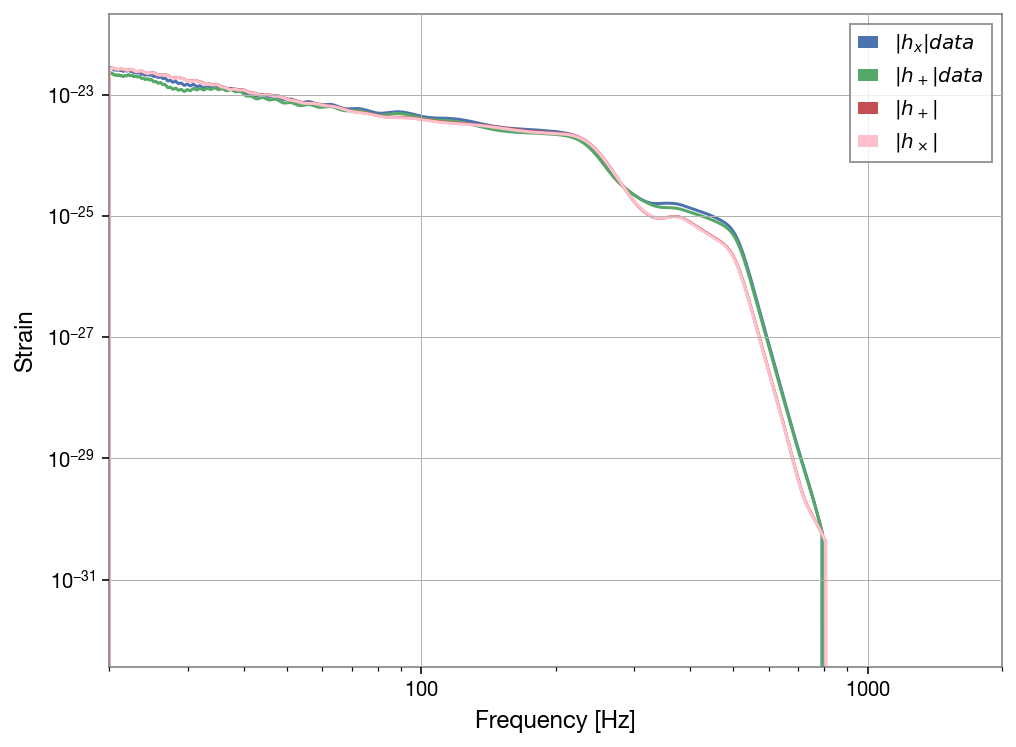

In [23]:
freq_data = freqwave["h_plus"].frequencies
hp_data = freqwave["h_plus"]
hx_data = freqwave["h_cross"]


fig = plt.figure(figsize=(8,6))
plt.plot(freq_data, abs(hp_data),'b',label=r"$|h_x| data$")
plt.loglog(freq_data, abs(hx_data),'g',label=r"$|h_+| data$")

plt.loglog(fs_gen,abs(hp_gen),'r',label=r'$|h_+|$')
plt.plot(fs_gen,abs(hx_gen),'pink',label=r'$|h_\times|$')
plt.xlabel(r'Frequency [Hz]')
plt.ylabel(r'Strain')
plt.xlim([20,2e3])
plt.legend()
plt.show()

## PSD interpolation function
since we have to make sure that the integration is performed on the same point on the frequency space. we interpolate PSD data with freq positions from strain waveoform as follow:

In [24]:


def PSD(freq,strain) :
    return interpolate.interp1d( freq, strain ) 
psd = PSD(psd_freq_h1,psd_strain_h1)
PSD(psd_freq_l1,psd_strain_l1),PSD(psd_freq_v1,psd_strain_v1)


(<scipy.interpolate._interpolate.interp1d at 0x124327400>,
 <scipy.interpolate._interpolate.interp1d at 0x125737090>)

/Users/kam/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


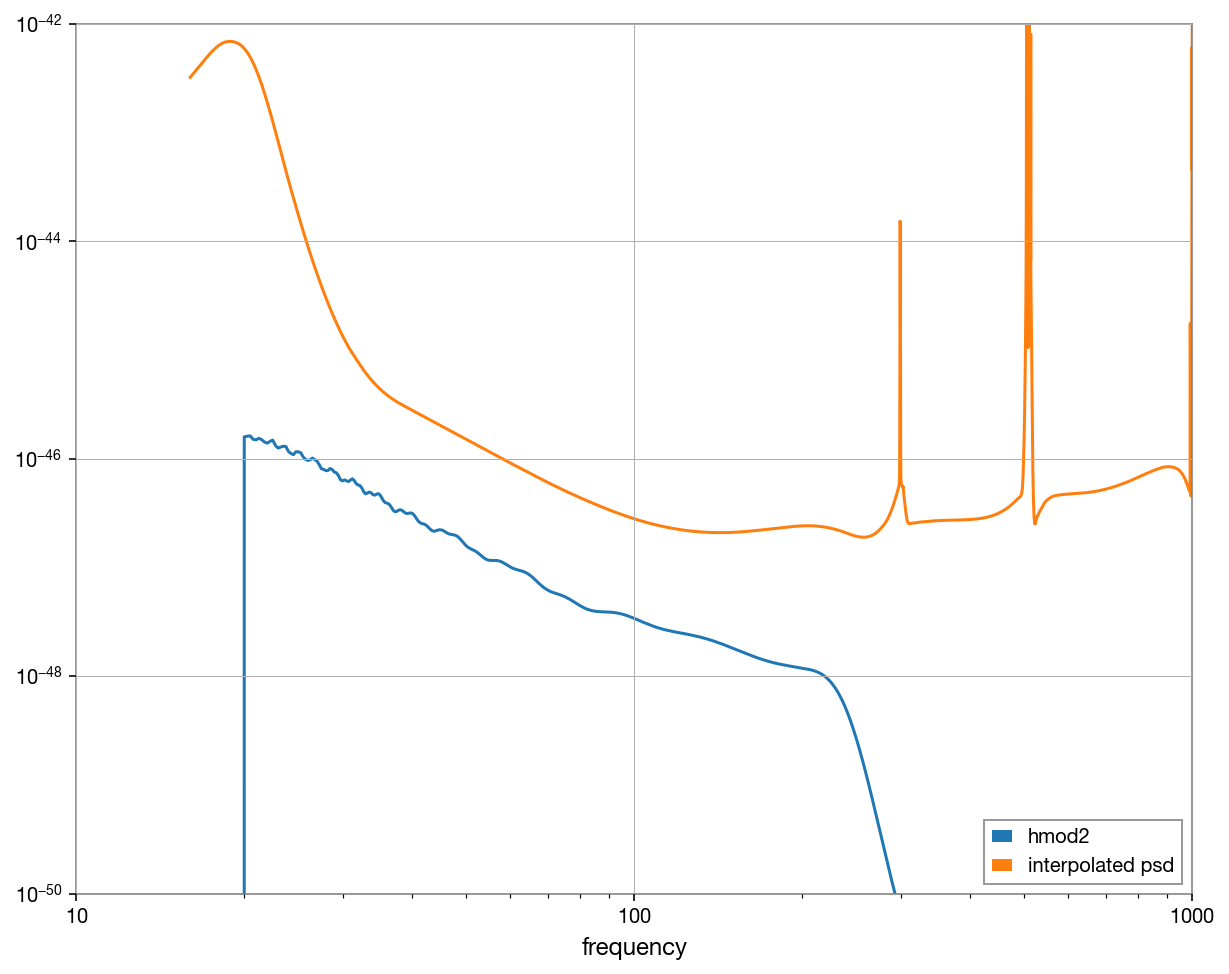

In [19]:
plt.figure(figsize=(10, 8))          
plt.yscale('log')
plt.xscale('log')
plt.xlabel('frequency')
plt.xlim(10,1000)
plt.ylim(1e-50,1e-42)
plt.plot(fs_gen[64:4095], Hmod2[64:4095],label='hmod2' ) #magnitude too small
plt.plot(fs_gen[64:4095], psd(fs_gen[64:4095]) ,label='interpolated psd')
#plt.plot(psd_freq_h1,psd_strain_h1,label='psd')
plt.legend()
plt.show()

## Final step: calculate SNR by using integration

In [20]:
#PSD(psd_freq_l1,psd_strain_l1)
#PSD(psd_freq_h1,psd_strain_h1)

def SNR(fs,hmod2,PSDf,PSDs ):
    f = interpolate.interp1d( PSDf, PSDs ) 
    inte = hmod2[(fs>20)&(fs<400)]/f(fs[(fs>20)&(fs<400)])

    return np.sqrt( 4*trapezoid(inte,fs[(fs>20)&(fs<400)] ) )


snrL = SNR(fs_gen,Hmod2,psd_freq_l1,psd_strain_l1)
snrH = SNR(fs_gen,Hmod2,psd_freq_h1,psd_strain_h1)
snrV = SNR(fs_gen,Hmod2,psd_freq_v1,psd_strain_v1)

'NETWORK SNR', np.sqrt(snrV**2 + snrH**2 + snrL**2), snrL, snrH, snrV

('NETWORK SNR',
 Array(13.43433521+0.j),
 Array(9.56219778+0.j),
 Array(8.49742375+0.j),
 Array(4.10359913+0.j))

In [21]:
binary_parameters = dict(
        mass_1= posterior_samples['mass_1'].mean(),
        mass_2= posterior_samples['mass_2'].mean(),
        a_1 = posterior_samples['a_1'].mean() ,
        a_2 = posterior_samples['a_2'].mean(),
        tilt_1= posterior_samples['tilt_1'].mean(),
        tilt_2= posterior_samples['tilt_2'].mean(),
        phi_12= posterior_samples['phi_12'].mean(),
        phi_jl= posterior_samples['phi_jl'].mean(),
        luminosity_distance = posterior_samples['luminosity_distance'].mean(), 
        theta_jn = posterior_samples['theta_jn'].mean(),
        psi = posterior_samples['psi'].mean(), 
        phase = posterior_samples['phase'].mean(),
        geocent_time = 1267963151.3,  # ****************
        ra = posterior_samples['ra'].mean(), 
        dec = posterior_samples['dec'].mean(), 
        chi1 =  -0.02 #spin for object 1 (but this is a number of chi_eff) ****************
    )
binary_parameters

{'mass_1': Array(42.78436737),
 'mass_2': Array(32.78978477),
 'a_1': Array(0.42350285),
 'a_2': Array(0.44845978),
 'tilt_1': Array(1.61840094),
 'tilt_2': Array(1.7112719),
 'phi_12': Array(3.12384784),
 'phi_jl': Array(2.79422747),
 'luminosity_distance': Array(1154.98429137),
 'theta_jn': Array(0.59442731),
 'psi': Array(1.65966681),
 'phase': Array(3.10052048),
 'geocent_time': 1267963151.3,
 'ra': Array(0.21191319),
 'dec': Array(-0.13770171),
 'chi1': -0.02}

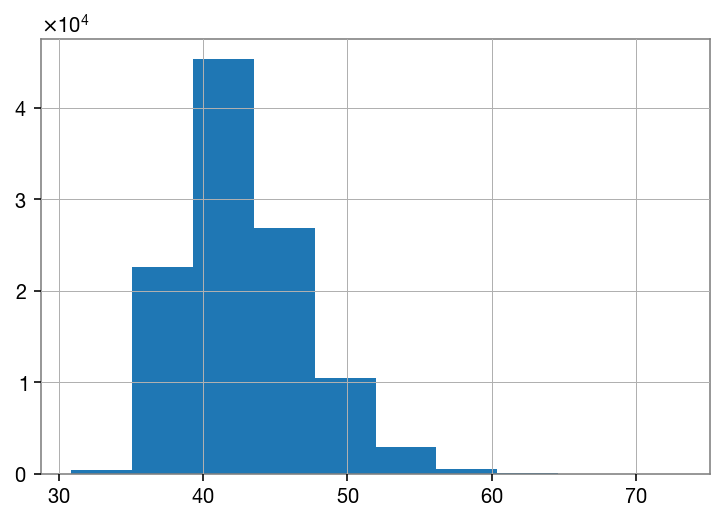

Array(42.78436737)

In [22]:
m1 = posterior_samples['mass_1']
plt.hist(m1)
plt.show()
posterior_samples['mass_1'].mean()

In [29]:
data2 = read("IGWN-GWTC3p0-v1-GW200311_115853_PEDataRelease_mixed_cosmo.h5")

index = 100
delta_f = 0.1
f_low = 10
f_high =1600



#approximant2 = "IMRPhenomXPHM"
#freqwave = samples_dict["C01:IMRPhenomXPHM"].maxL_fd_waveform(approximant2, delta_f, f_low, f_high)

2023-02-08  13:42:15 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2023-02-08  13:42:15 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2023-02-08  13:42:15 PESummary WARNING : Could not find minimum frequency in input file and one was not passed from the command line. Using 20.0Hz as default


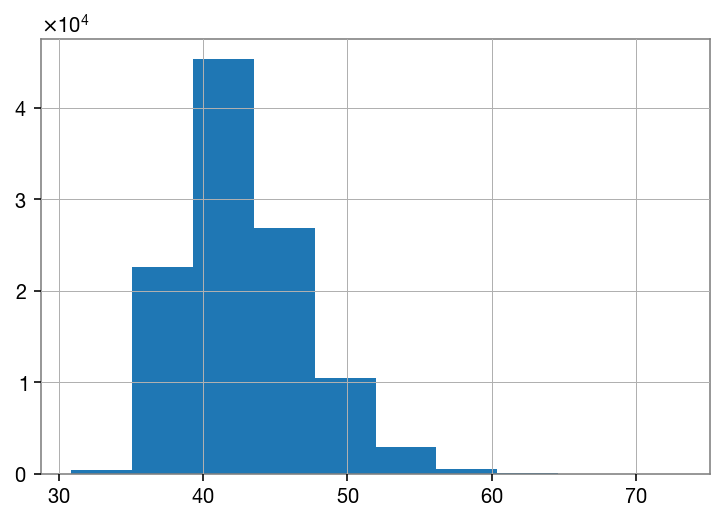

Array(42.78436737)

In [31]:
samples_dict2 = data2.samples_dict
posterior_samples2 = samples_dict2["C01:IMRPhenomXPHM"]

mass1 = posterior_samples2['mass_1']
plt.hist(m1)
plt.show()
posterior_samples['mass_1'].mean()